### 测试数据集

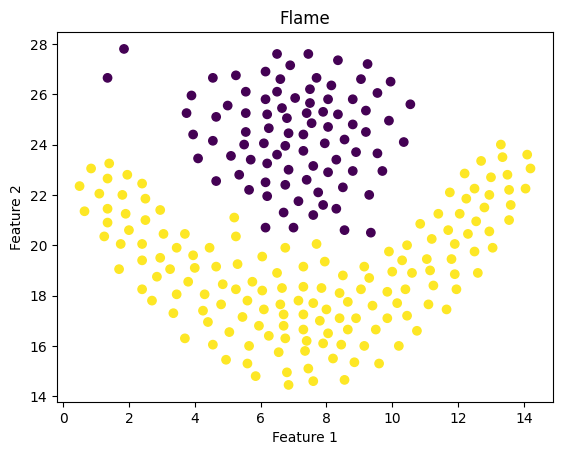

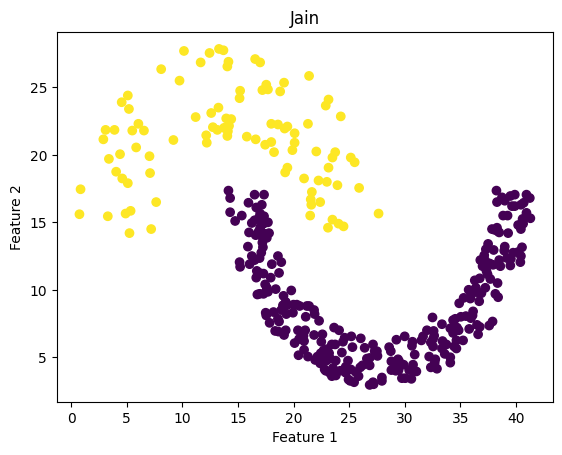

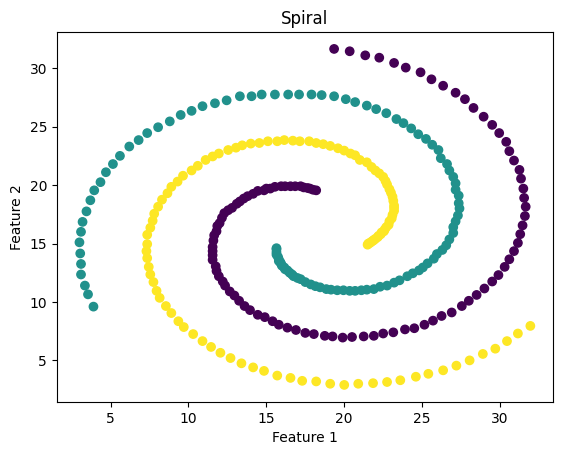

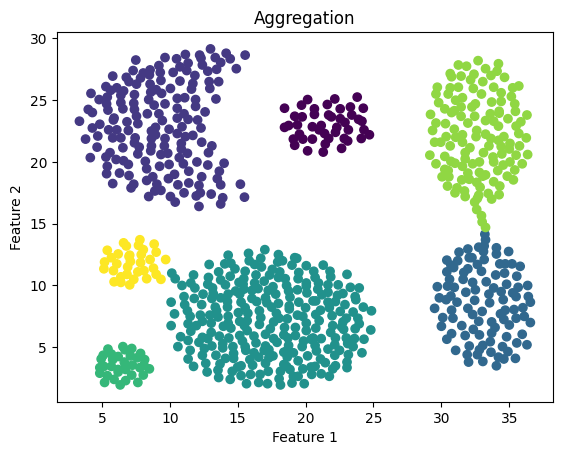

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def load_data(dataset_name):
    if dataset_name == 'Flame':
        data = np.loadtxt('data/data/flame.txt')
    elif dataset_name == 'Jain':
        data = np.loadtxt('data/data/jain.txt')
    elif dataset_name == 'Spiral':
        data = np.loadtxt('data/data/spiral.txt')
    elif dataset_name == 'Aggregation':
        data = np.loadtxt('data/data/aggregation.txt')
    else:
        raise ValueError("Unknown dataset name")
    
    X = data[:, :-1]
    labels = data[:, -1].astype(int)
    return X, labels

def plot_data(X, labels, title):
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

datasets = ['Flame', 'Jain', 'Spiral', 'Aggregation']
for dataset in datasets:
    X, labels = load_data(dataset)
    plot_data(X, labels, dataset)

### 开始手搓DPC

In [ ]:
import math
import numpy as np


class DensityPeakCluster(object):
    """
    Density Peak Cluster.
    Methods:
        fit: fit model
        plot: plot clustering
        
    Attributes:
        n_id: data row count
        distance: each id distance
        dc: threshold of density cut off
        rho: each id density
        nneigh: each id min upper density nearest neighbor
        delta: each id min upper density nearest neighbor distance
        labels_: cluster labels_
        center: center id
    """

    def __init__(self,
                 dc=None,
                 distance_metric='euclidean',
                 silence=True,
                 gauss_cutoff=True,
                 density_threshold=None,
                 distance_threshold=None,
                 anormal=True):
        """
        Init parameters for Density peak cluster.

        parameters
        :param dc: local density threshold, None for default select, 'auto' for auto select
        :param distance_metric: distance calculate function, include euclidean, cosine, pearson
        :param silence: print process log
        :param gauss_cutoff: neighbor cutoff function, True for gauss, False for hard cutoff
        :param density_threshold: density threshold to filter center, None for auto
        :param distance_threshold: distance threshold to filter center, None for auto
        :param anormal: differ anormal point to -1
        """

        self.dc = dc
        self.distance_metric = distance_metric
        self.silence = silence
        self.gauss_cutoff = gauss_cutoff
        self.density_threshold = density_threshold
        self.distance_threshold = distance_threshold
        self.anormal = anormal

    def build_distance(self):
        """
        Calculate distance dict.

        :return: distance dict, max distance, min distance
        """
        from scipy.spatial.distance import pdist, squareform

        distance_matrix = pdist(self.data, metric=self.distance_metric)
        distance_matrix = squareform(distance_matrix)

        triangle_upper = np.triu_indices(self.data.shape[0], 1)
        triangle_upper = distance_matrix[triangle_upper]

        distance = {}
        for i in range(self.n_id):
            for j in range(i + 1, self.n_id):
                distance[(i, j)] = distance_matrix[i, j]
                distance[(j, i)] = distance_matrix[i, j]

        max_dis, min_dis = np.max(triangle_upper), np.min(triangle_upper)

        return distance, max_dis, min_dis

    def auto_select_dc(self):
        max_dis, min_dis = self.max_dis, self.min_dis
        dc = (max_dis + min_dis) / 2

        while True:
            nneighs = sum([1 for v in self.distances.values() if v < dc]) / self.n_id ** 2
            if 0.01 <= nneighs <= 0.002:
                break
            # binary search
            if nneighs < 0.01:
                min_dis = dc
            else:
                max_dis = dc
            dc = (max_dis + min_dis) / 2
            # dc的值足够精确
            if max_dis - min_dis < 0.0001:
                break
        return dc

    def select_dc(self):
        if self.dc == 'auto':
            dc = self.auto_select_dc()
        else:
            percent = 2.0
            position = int(self.n_id * (self.n_id + 1) / 2 * percent / 100)
            dc = np.sort(list(self.distances.values()))[position * 2 + self.n_id]

        return dc

    def local_density(self):
        """
        Compute all points' local density.

        :return: local density vector that index is the point index
        """
        guass_func = lambda dij, dc: math.exp(- (dij / dc) ** 2)
        cutoff_func = lambda dij, dc: 1 if dij < dc else 0
        func = guass_func if self.gauss_cutoff else cutoff_func
        rho = [0] * self.n_id
        for i in range(self.n_id):
            for j in range(i + 1, self.n_id):
                temp = func(self.distances[(i, j)], self.dc)
                rho[i] += temp
                rho[j] += temp
        return np.array(rho, np.float32)

    def min_neighbor_and_distance(self):
        """
        Compute all points' min util to the higher local density point(which is the nearest neighbor).

        :return: distance vector, nearest neighbor vector
        """
        sort_rho_idx = np.argsort(-self.rho)
        delta, nneigh = [float(self.max_dis)] * (self.n_id), [0] * self.n_id
        delta[sort_rho_idx[0]] = -1.
        for i in range(self.n_id):
            for j in range(0, i):
                old_i, old_j = sort_rho_idx[i], sort_rho_idx[j]
                if self.distances[(old_i, old_j)] < delta[old_i]:
                    delta[old_i] = self.distances[(old_i, old_j)]
                    nneigh[old_i] = old_j
        delta[sort_rho_idx[0]] = max(delta)

        return np.array(delta, np.float32), np.array(nneigh, np.float32)

    def collapse(self):
        """
        Clustering.

        :return: None
        """
        cluster, center = {}, {}  # cl/icl in cluster_dp.m

        if self.density_threshold is None:
            self.density_threshold = (min(self.rho) + max(self.rho)) / 2

        if self.distance_threshold is None:
            self.distance_threshold = (min(self.delta) + max(self.delta)) / 2

        # init center and other point
        for idx, (ldensity, mdistance, nneigh_item) in enumerate(zip(self.rho, self.delta, self.nneigh)):
            if ldensity >= self.density_threshold and mdistance >= self.distance_threshold:
                center[idx] = idx
                cluster[idx] = idx
            else:
                cluster[idx] = -1

        # assignation
        ordrho = np.argsort(-self.rho)
        for i in range(ordrho.shape[0]):
            if cluster[ordrho[i]] == -1:
                cluster[ordrho[i]] = cluster[self.nneigh[ordrho[i]]]

        # halo
        halo, bord_rho = {}, {}
        for i in range(ordrho.shape[0]):
            halo[i] = cluster[i]
        if len(center) > 0:
            for idx in center.keys():
                bord_rho[idx] = 0.0
            for i in range(self.rho.shape[0]):
                for j in range(i + 1, self.rho.shape[0]):
                    if cluster[i] != cluster[j] and self.distances[i, j] <= self.dc:
                        rho_aver = (self.rho[i] + self.rho[j]) / 2.0
                        if rho_aver > bord_rho[cluster[i]]:
                            bord_rho[cluster[i]] = rho_aver
                        if rho_aver > bord_rho[cluster[j]]:
                            bord_rho[cluster[j]] = rho_aver
            for i in range(self.rho.shape[0]):
                if self.rho[i] < bord_rho[cluster[i]]:
                    halo[i] = 0

        if self.anormal:
            for i in range(self.rho.shape[0]):
                if halo[i] == 0:
                    cluster[i] = - 1

        labels_ = np.zeros(self.n_id).astype(int)
        for k in cluster:
            labels_[k] = cluster[k]

        return labels_, list(center.values())

    def fit(self, data):
        """
        Fit model.

        :param data: data for cluster
        :return: None
        """
        if isinstance(data, np.ndarray): data = np.array(data)

        self.data = data
        self.n_id = data.shape[0]

        # calculate distance
        self.distances, self.max_dis, self.min_dis = self.build_distance()

        # select dc
        self.dc = self.select_dc()

        # calculate local density
        self.rho = self.local_density()

        # calculate nearest neighbor and delta
        self.delta, self.nneigh = self.min_neighbor_and_distance()

        # clustering
        self.labels_, self.center = self.collapse()

    def plot(self, mode="all", title="", **kwargs):
        """
        Plot cluster.

        :param mode: "decision" to plot decision graph,
            "label" to plot label graph, "all" to plot decision and label graph.
        :param title: title to plot
        :return: None
        """
        import matplotlib.pyplot as plt
        from dpca.plot_utils import plot_scatter

        if mode not in {"decision", "label", "all"}:
            raise ValueError("mode must be one of [decision, label, all].")

        if mode in ["decision", "all"]:
            title_ = "decision graph" if title == "" else title + " decision graph"
            plot_scatter(np.vstack((self.rho, self.delta)).T,
                         self.labels_, x_label='density', y_label='distance', title=title_, **kwargs)

        if mode in ["label", "all"]:
            title_ = "label graph" if title == "" else title + " label graph"
            plot_scatter(self.data, self.labels_, title=title_, **kwargs)

        plt.show()